<a href="https://colab.research.google.com/github/vaibhavraok/GNCIPL/blob/main/Credit_card_transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset_path = kagglehub.dataset_download("tjverry/credit-card-transactions")
print("Dataset downloaded to:", dataset_path)

# Find CSV files
csv_files = [f for f in os.listdir(dataset_path) if f.endswith(".csv")]
print("Available CSV files:", csv_files)

if len(csv_files) == 0:
    raise FileNotFoundError("No CSV files found in dataset. Please check dataset contents.")

file_path = os.path.join(dataset_path, csv_files[0])
print("Using file:", file_path)

# Load dataset
df = pd.read_csv(file_path)
print("Shape of dataset:", df.shape)
print("\nColumns:", df.columns.tolist())
df.head()

100%|██████████| 21.3M/21.3M [00:00<00:00, 94.1MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/tjverry/credit-card-transactions/versions/1
Available CSV files: ['transactions.csv']
Using file: /root/.cache/kagglehub/datasets/tjverry/credit-card-transactions/versions/1/transactions.csv
Shape of dataset: (786363, 22)

Columns: ['accountNumber', 'creditLimit', 'availableMoney', 'transactionDateTime', 'merchantName', 'transactionAmount', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'transactionType', 'currentBalance', 'cardPresent', 'expirationDateKeyInMatch', 'isFraud']


,accountNumber,creditLimit,availableMoney,transactionDateTime,merchantName,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,5000,5000.0,2016-08-13T14:27:32,Uber,98.55,US,US,2.0,1.0,...,3/14/2015,3/14/2015,414,414,1803,PURCHASE,0.0,0,0,0
1,737265056,5000,5000.0,2016-10-11T05:05:54,AMC #191138,74.51,US,US,9.0,1.0,...,3/14/2015,3/14/2015,486,486,767,PURCHASE,0.0,1,0,0
2,737265056,5000,5000.0,2016-11-08T09:18:39,Play Store,7.47,US,US,9.0,1.0,...,3/14/2015,3/14/2015,486,486,767,PURCHASE,0.0,0,0,0
3,737265056,5000,5000.0,2016-12-10T02:14:50,Play Store,7.47,US,US,9.0,1.0,...,3/14/2015,3/14/2015,486,486,767,PURCHASE,0.0,0,0,0
4,830329091,5000,5000.0,2016-03-24T21:04:46,Tim Hortons #947751,71.18,US,US,2.0,1.0,...,8/6/2015,8/6/2015,885,885,3143,PURCHASE,0.0,1,0,0


In [4]:
print("Missing Values:\n", df.isnull().sum())
print("\nDuplicates before:", df.duplicated().sum())

# Drop duplicates
df = df.drop_duplicates()
print("Duplicates after:", df.duplicated().sum())
print("Shape after cleaning:", df.shape)

Missing Values:
 accountNumber                  0
creditLimit                    0
availableMoney                 0
transactionDateTime            0
merchantName                   0
transactionAmount              0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
currentExpDate                 0
accountOpenDate                0
dateOfLastAddressChange        0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
dtype: int64

Duplicates before: 0
Duplicates after: 0
Shape after cleaning: (786363, 22)


Available columns:
 ['accountNumber', 'creditLimit', 'availableMoney', 'transactionDateTime', 'merchantName', 'transactionAmount', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'transactionType', 'currentBalance', 'cardPresent', 'expirationDateKeyInMatch', 'isFraud']


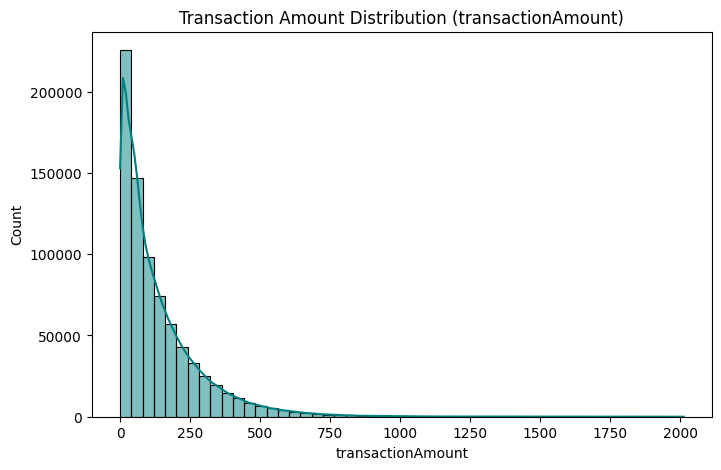

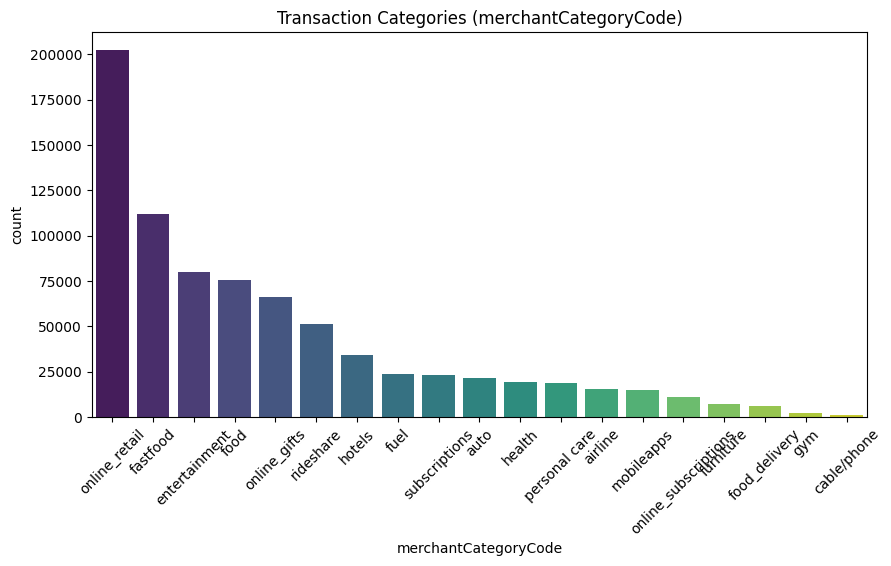

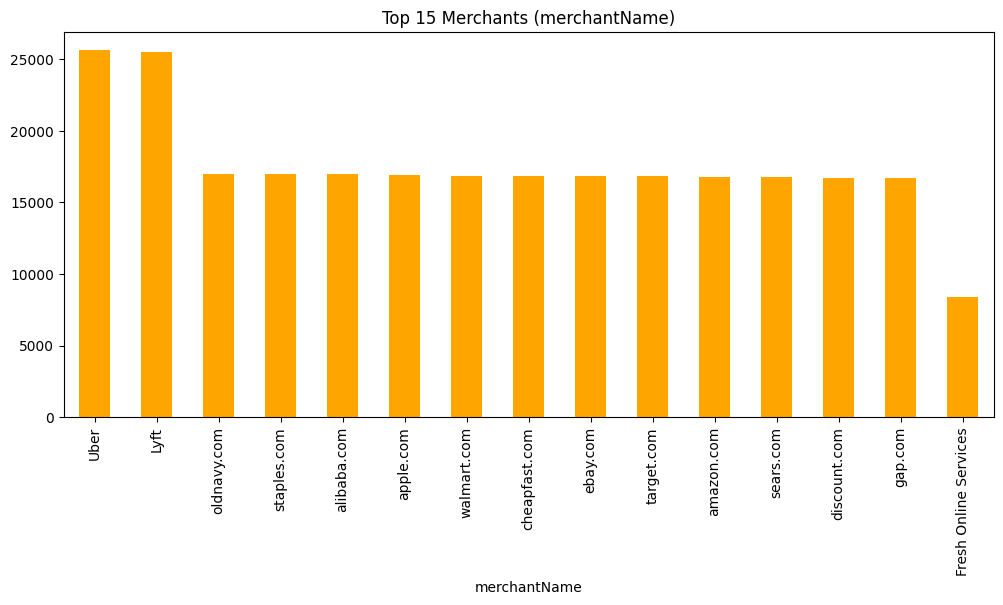

In [5]:
print("Available columns:\n", df.columns.tolist())

# --- Transaction Amount Distribution ---
amount_col = None
for col in df.columns:
    if "amt" in col.lower() or "amount" in col.lower() or "value" in col.lower():
        amount_col = col
        break

if amount_col:
    plt.figure(figsize=(8,5))
    sns.histplot(df[amount_col], bins=50, kde=True, color="teal")
    plt.title(f"Transaction Amount Distribution ({amount_col})")
    plt.show()
else:
    print(" No amount-like column found.")

# --- Category Distribution ---
category_col = None
for col in df.columns:
    if "category" in col.lower():
        category_col = col
        break

if category_col:
    plt.figure(figsize=(10,5))
    sns.countplot(data=df, x=category_col,
                  order=df[category_col].value_counts().index,
                  palette="viridis")
    plt.xticks(rotation=45)
    plt.title(f"Transaction Categories ({category_col})")
    plt.show()
else:
    print(" No category-like column found.")

# --- Merchant Distribution ---
merchant_col = None
for col in df.columns:
    if "merchant" in col.lower() or "store" in col.lower():
        merchant_col = col
        break

if merchant_col:
    plt.figure(figsize=(12,5))
    df[merchant_col].value_counts().head(15).plot(kind="bar", color="orange")
    plt.title(f"Top 15 Merchants ({merchant_col})")
    plt.show()
else:
    print(" No merchant-like column found.")

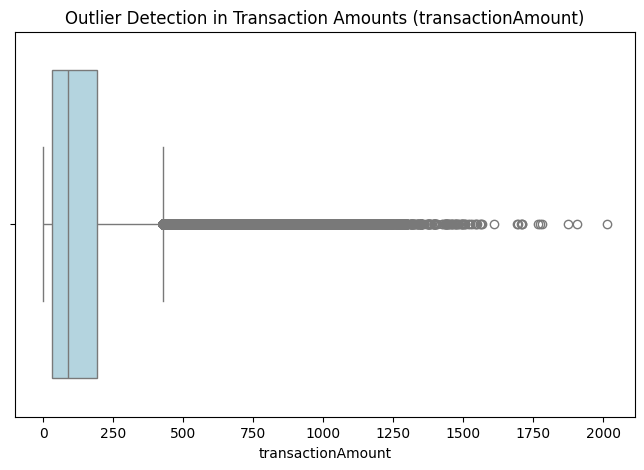

Number of potential outliers (amount): 14933


In [6]:
if amount_col:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=df[amount_col], color="lightblue")
    plt.title(f"Outlier Detection in Transaction Amounts ({amount_col})")
    plt.show()

    # Z-score method
    df['zscore_amount'] = (df[amount_col] - df[amount_col].mean()) / df[amount_col].std()
    outliers = df[df['zscore_amount'].abs() > 3]
    print("Number of potential outliers (amount):", outliers.shape[0])

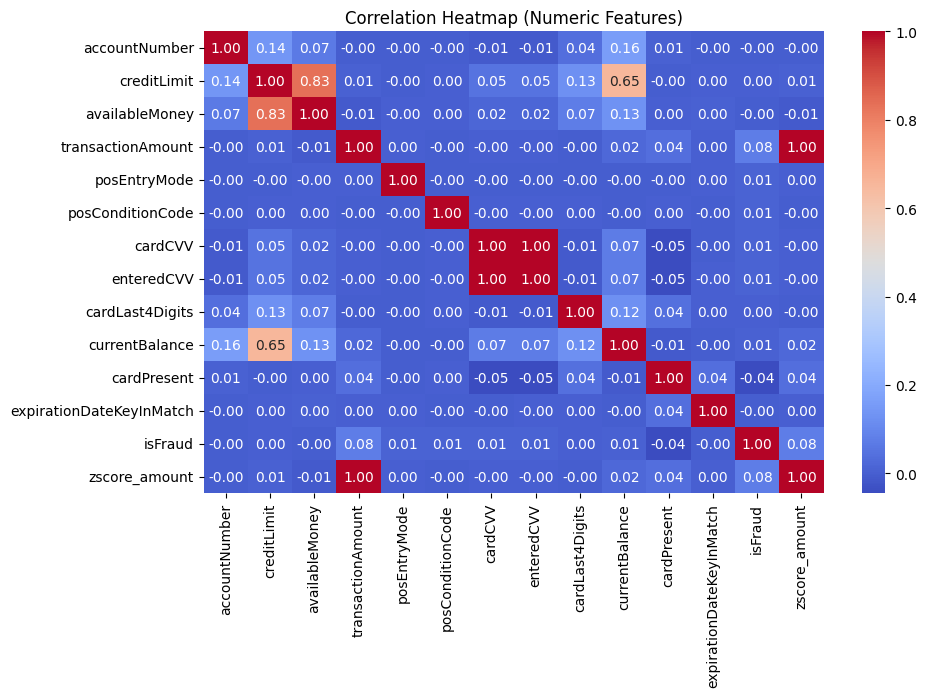

In [7]:
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

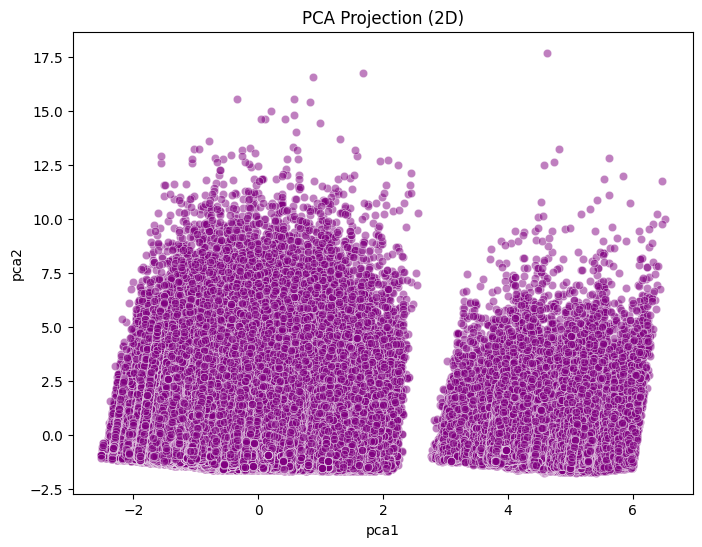

In [9]:
if numeric_df.shape[1] > 2:  # only if enough numeric columns
    # Drop NaN consistently
    clean_numeric = numeric_df.dropna()

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(clean_numeric)

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)

    # Create a PCA dataframe aligned with clean_numeric
    pca_df = pd.DataFrame(pca_result, columns=["pca1", "pca2"], index=clean_numeric.index)

    # Merge back into main df
    df = df.join(pca_df)

    plt.figure(figsize=(8,6))
    sns.scatterplot(x="pca1", y="pca2", data=df, alpha=0.5, color="purple")
    plt.title("PCA Projection (2D)")
    plt.show()
else:
    print("Not enough numeric features for PCA.")

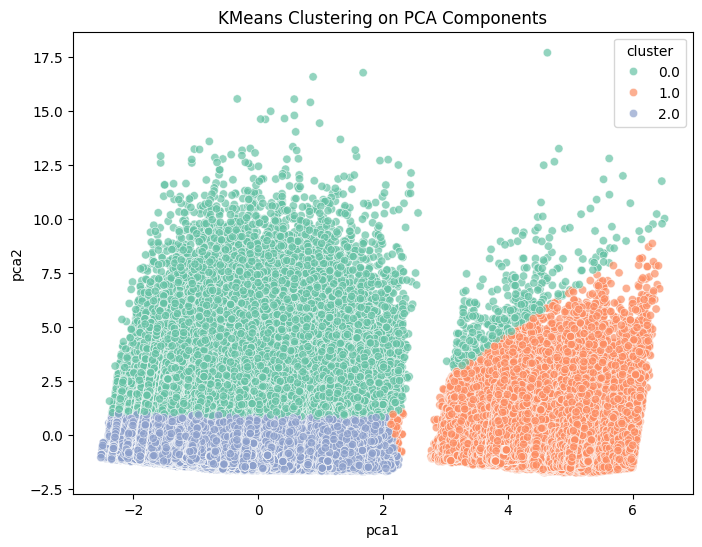

In [11]:
if 'pca1' in df.columns and 'pca2' in df.columns:
    # Keep only rows with valid PCA values
    clean_pca = df[['pca1', 'pca2']].dropna()

    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(clean_pca)

    # Assign back safely
    df.loc[clean_pca.index, 'cluster'] = clusters

    # Plot clustering result
    plt.figure(figsize=(8,6))
    sns.scatterplot(x="pca1", y="pca2", hue="cluster", data=df, palette="Set2", alpha=0.7)
    plt.title("KMeans Clustering on PCA Components")
    plt.show()
else:
    print(" PCA not available, skipping clustering.")

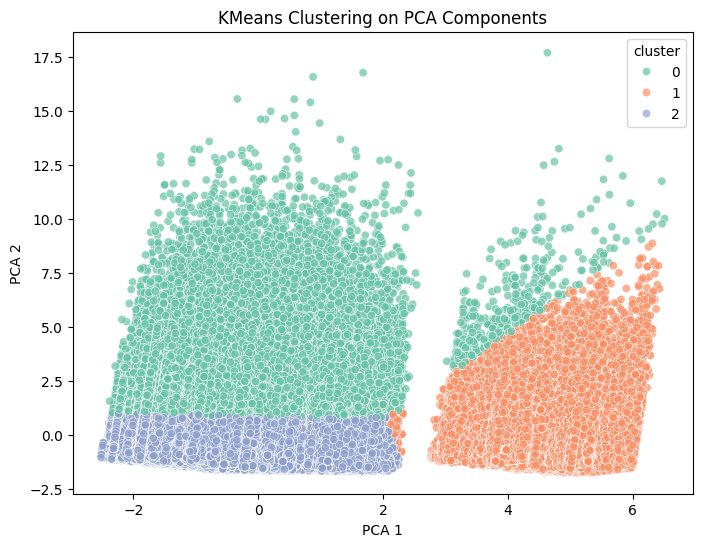

In [12]:
df_clust = df.dropna(subset=['pca1', 'pca2']).copy()
kmeans = KMeans(n_clusters=3, random_state=42)
df_clust['cluster'] = kmeans.fit_predict(df_clust[['pca1','pca2']])

plt.figure(figsize=(8,6))
sns.scatterplot(x="pca1", y="pca2", hue="cluster", data=df_clust, palette="Set2", alpha=0.7)
plt.title("KMeans Clustering on PCA Components")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

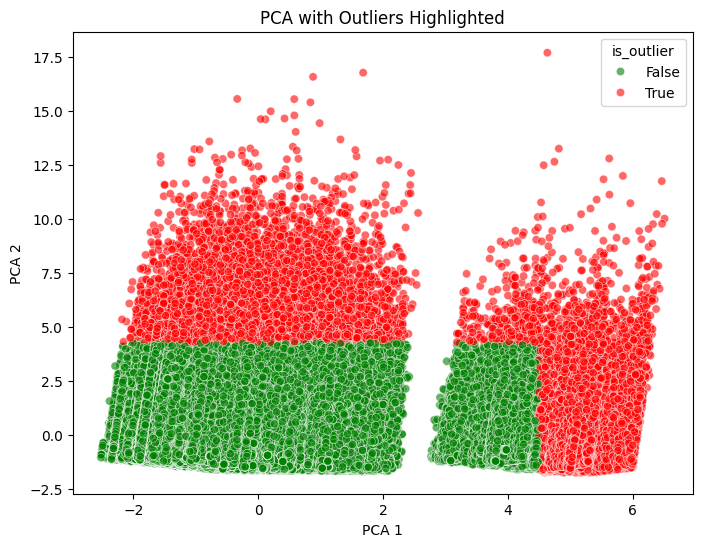

In [14]:
from scipy import stats
import numpy as np

# Work only on rows with PCA values
df_clust = df[['pca1','pca2']].dropna().copy()

# Outlier detection using Z-score
z_scores = np.abs(stats.zscore(df_clust))
df_clust['is_outlier'] = (z_scores > 3).any(axis=1)  # mark True if any z-score > 3

# Plot PCA with outliers
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="pca1", y="pca2",
    hue="is_outlier",
    data=df_clust,
    palette={True:"red", False:"green"},
    alpha=0.6
)
plt.title("PCA with Outliers Highlighted")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [15]:
if 'customerRegion' in df.columns:
    plt.figure(figsize=(12,5))
    sns.boxplot(x="customerRegion", y="transactionAmount", data=df)
    plt.title("Transaction Amount by Customer Region")
    plt.xticks(rotation=45)
    plt.show()

if 'customerAge' in df.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(df['customerAge'], bins=30, kde=True, color="skyblue")
    plt.title("Customer Age Distribution")
    plt.show()

In [17]:
if 'merchantLongitude' in df.columns and 'merchantLatitude' in df.columns:
    plt.figure(figsize=(10,6))
    sns.scatterplot(x="merchantLongitude", y="merchantLatitude", hue="transactionAmount", data=df, palette="viridis", alpha=0.7)
    plt.title("Geospatial Distribution of Transactions")
    plt.show()